<a href="https://colab.research.google.com/github/AllejandroSousa/BERT-MLM/blob/main/examples/nlp/ipynb/masked_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Masked Language Modeling with BERT

**Team:** [Allejandro Sousa](https://github.com/AllejandroSousa), [José Samuel](https://github.com/Samuel-IA7), [Vinícius Germano]()<br>
**Date created:** 2025/04/03<br>
**Last modified:** 2025/04/03<br>
**Description:** "Implement a Masked Language Model (MLM) using BERT and fine-tune it on the Stack Overflow Questions/Answers dataset. Additionally, implement a Markov chain for the same problem and compare the results."

## Introduction

Masked Language Modeling is a fill-in-the-blank task,
where a model uses the context words surrounding a mask token to try to predict what the
masked word should be.

For an input that contains one or more mask tokens,
the model will generate the most likely substitution for each.

Example:

- Input: "SyntaxError: Unexpected [mask]."
- Output: "SyntaxError: Unexpected token."

Masked language modeling is a great way to train a language
model in a self-supervised setting (without human-annotated labels).
Such a model can then be fine-tuned to accomplish various supervised
NLP tasks.

This example teaches you how to build a BERT model from scratch,
train it with the masked language modeling task,
and then fine-tune this model on a sentiment classification task.
Additionally, we implement a Markov Chain-based approach to perform the same masked language modeling task and subsequent sentiment classification, allowing us to compare the results of these two distinct methods.

We will use the Keras `TextVectorization` and `MultiHeadAttention` layers
to create a BERT Transformer-Encoder network architecture, while the Markov Chain model leverages probabilistic transitions between words to predict masked tokens and generate features for classification.

In [1]:
import os  # Importa a biblioteca 'os' para interagir com o sistema operacional, como definir variáveis de ambiente.

os.environ["KERAS_BACKEND"] = "torch"  # Define o backend do Keras como 'torch' (PyTorch). Isso determina qual biblioteca de baixo nível será usada para cálculos. Outras opções incluem 'jax' ou 'tensorflow'.

import keras_hub  # Importa o Keras Hub, uma biblioteca que oferece camadas e modelos pré-construídos, especialmente úteis para tarefas de processamento de linguagem natural (NLP).

import keras  # Importa o Keras, uma API de alto nível para criar e treinar modelos de deep learning de forma simplificada.
from keras import layers  # Importa o módulo 'layers' do Keras, que contém componentes como camadas densas, embeddings, etc.
from keras.layers import TextVectorization  # Importa especificamente a camada 'TextVectorization', usada para converter texto em sequências numéricas.

from dataclasses import dataclass  # Importa o decorador 'dataclass' do Python, que facilita a criação de classes para armazenar dados.
import pandas as pd  # Importa a biblioteca Pandas, amplamente usada para manipulação de dados em formato tabular.
import numpy as np  # Importa o NumPy, essencial para operações numéricas rápidas e eficientes com arrays.
import glob  # Importa a biblioteca 'glob' para encontrar arquivos no sistema usando padrões (ex.: '*.csv').
import re  # Importa a biblioteca de expressões regulares ('re') para manipulação avançada de strings.
from pprint import pprint  # Importa a função 'pprint' para exibir dados de forma estruturada e legível.

## Set-up Configuration

In [2]:

@dataclass
class Config:
    """
    Classe de configuração que define hiperparâmetros fixos para o modelo.

    Atributos:
        MAX_LEN (int): Comprimento máximo das sequências de texto após a vetorização.
        BATCH_SIZE (int): Número de amostras processadas por lote durante o treinamento.
        LR (float): Taxa de aprendizado (learning rate) usada pelo otimizador.
        VOCAB_SIZE (int): Tamanho máximo do vocabulário para a camada de vetorização.
        EMBED_DIM (int): Dimensão dos vetores de embedding gerados para cada palavra.
        NUM_HEAD (int): Número de cabeças de atenção no modelo BERT, usado no mecanismo de atenção multi-cabeça.
        FF_DIM (int): Dimensão da camada feed-forward interna do BERT.
        NUM_LAYERS (int): Número de camadas de codificação no modelo BERT.
    """
    MAX_LEN = 256  # Define o comprimento máximo das sequências como 256 tokens.
    BATCH_SIZE = 32  # Define o tamanho do lote como 32 amostras.
    LR = 0.001  # Define a taxa de aprendizado como 0.001 (um valor comum para iniciar).
    VOCAB_SIZE = 30000  # Limita o vocabulário a 30.000 palavras mais frequentes.
    EMBED_DIM = 128  # Define a dimensão dos embeddings como 128.
    NUM_HEAD = 8  # Configura 8 cabeças de atenção para o BERT.
    FF_DIM = 128  # Define a dimensão da camada feed-forward como 128.
    NUM_LAYERS = 1  # Usa apenas 1 camada de codificação no BERT.

config = Config()  # Cria uma instância da classe Config para acessar os hiperparâmetros ao longo do código.

## Load the Data

First, we will download the Stack Overflow dataset and load it into a Pandas DataFrame.

### Important: Kaggle API Setup

If you haven't uploaded the `kaggle.json` file to your Colab environment, follow these steps:

1. Go to [Kaggle](https://www.kaggle.com).
2. Log in to your account (or create one if you don’t have one).
3. Navigate to **Settings**.
4. Locate the **API** section and click on **Create New Token**.
5. A `kaggle.json` file will be downloaded.
6. Upload this file to your Colab environment before running the code below.

Once the `kaggle.json` file is uploaded, proceed with the code execution.


In [3]:
!pip install -q kaggle

# Configurar o arquivo kaggle.json (após upload manual)
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixar o dataset
!kaggle datasets download -d stackoverflow/stacksample

# Descompactar
!unzip stacksample.zip

mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/stackoverflow/stacksample
License(s): other
stacksample.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  stacksample.zip
replace Answers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
from sklearn.model_selection import train_test_split

# Carregar o dataset (assumindo que você baixou 'Questions.csv' do Kaggle)
df = pd.read_csv("Questions.csv", encoding='latin-1')

# Filtrar para 200.000 exemplos e criar rótulos binários
df = df.sample(n=200000, random_state=42)  # Reduzir para 200.000
df["sentiment"] = df["Score"].apply(lambda x: 1 if x >= 1 else 0)  # 1 = positivo, 0 = negativo
df["review"] = df["Title"] + " " + df["Body"]  # Combinar título e corpo como texto principal

# Dividir em treino e teste (50/50 como o IMDB)
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)
all_data = pd.concat([train_df, test_df], ignore_index=True)

# Verificar o tamanho
print(f"Treino: {len(train_df)}, Teste: {len(test_df)}")

Treino: 100000, Teste: 100000


## Dataset preparation

We will use the `TextVectorization` layer to vectorize the text into integer token ids.
It transforms a batch of strings into either
a sequence of token indices (one sample = 1D array of integer token indices, in order)
or a dense representation (one sample = 1D array of float values encoding an unordered set of tokens).

Below, we define 3 preprocessing functions.

1.  The `get_vectorize_layer` function builds the `TextVectorization` layer.
2.  The `encode` function encodes raw text into integer token ids.
3.  The `get_masked_input_and_labels` function will mask input token ids.
It masks 15% of all input tokens in each sequence at random.

In [9]:
# For data pre-processing and tf.data.Dataset
import tensorflow as tf


def custom_standardization(input_data):
    """
    Prepara o texto de entrada limpando e uniformizando ele para ser usado em um modelo.

    Essa função faz uma limpeza no texto bruto para que ele fique em um formato mais simples e consistente antes de ser transformado em números que o modelo consegue entender. Ela:
    - Transforma todas as letras em minúsculas para evitar diferenças entre "Oi" e "oi".
    - Remove a tag HTML '<br />' (que significa quebra de linha) e coloca um espaço no lugar.
    - Tira todos os sinais de pontuação e caracteres especiais, deixando só letras, números e espaços.

    Args:
        input_data (tf.Tensor): O texto bruto que será limpo. É um objeto do TensorFlow que guarda o texto.

    Returns:
        tf.Tensor: O texto limpo e uniformizado, pronto para ser processado.

    Exemplo:
        Entrada: "Olá, Mundo! <br /> Como você está?"
        Saída: "olá mundo como você está"
    """
    lowercase = tf.strings.lower(input_data)  # Transforma todo o texto em letras minúsculas para consistência.
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")  # Substitui a tag '<br />' por um espaço simples.
    cleaned_text = tf.strings.regex_replace(
        stripped_html,  # Usa o texto já sem '<br />'.
        "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"),  # Define um padrão com todos os caracteres especiais a remover.
        ""  # Substitui esses caracteres por nada (remove eles).
    )
    return cleaned_text  # Retorna o texto limpo e pronto para uso.

# Links auxiliares:
# - [tf.strings.lower](https://www.tensorflow.org/api_docs/python/tf/strings/lower): Como funciona a conversão para minúsculas.
# - [tf.strings.regex_replace](https://www.tensorflow.org/api_docs/python/tf/strings/regex_replace): Explicação sobre substituição com expressões regulares.
# - [re.escape](https://docs.python.org/3/library/re.html#re.escape): Como escapar caracteres especiais em padrões.


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """
    Cria uma ferramenta que transforma textos em sequências de números para o modelo entender.

    Essa função faz uma camada especial que pega textos (frases ou palavras) e transforma cada palavra em um número único, como um código. Ela também define um limite de palavras diferentes (vocabulário) e corta ou completa as sequências para terem o mesmo tamanho.

    Args:
        texts (list): Uma lista de frases ou textos que serão usados para "ensinar" quais palavras são importantes.
        vocab_size (int): O número máximo de palavras diferentes que o modelo vai reconhecer.
        max_seq (int): O tamanho fixo que cada sequência de números vai ter (corta se for maior, completa se for menor).
        special_tokens (list, optional): Palavras especiais (como '[MASK]') que terão códigos próprios. Padrão é ['[MASK]'].

    Returns:
        layers.Layer: Uma camada configurada que pode transformar textos em números.

    Exemplo:
        texts = ["olá mundo", "olá terra"]
        vocab_size = 5
        max_seq = 3
        Resultado: Uma camada que transforma "olá mundo" em algo como [2, 3, 0].
    """
    vectorize_layer = TextVectorization(  # Cria a camada que vai transformar texto em números.
        max_tokens=vocab_size,  # Define o limite de palavras diferentes que ela vai aprender.
        output_mode="int",  # Faz a saída ser números inteiros (cada número é uma palavra).
        standardize=custom_standardization,  # Usa a função de limpeza que definimos antes.
        output_sequence_length=max_seq,  # Garante que todas as sequências tenham esse tamanho fixo.
    )
    vectorize_layer.adapt(texts)  # "Treina" a camada com os textos para ela aprender as palavras mais comuns.
    vocab = vectorize_layer.get_vocabulary()  # Pega a lista de palavras que a camada aprendeu.
    vocab = vocab[2:vocab_size - len(special_tokens)] + ["[mask]"]  # Tira as palavras padrão '[PAD]' e '[UNK]' e adiciona '[mask]'.
    vectorize_layer.set_vocabulary(vocab)  # Atualiza a camada com o novo vocabulário que inclui '[mask]'.
    return vectorize_layer  # Retorna a camada pronta para transformar textos em números.

# Links auxiliares:
# - [TextVectorization](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/): Documentação oficial da camada.
# - [Método adapt](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/#adapt-method): Como a camada aprende o vocabulário.


vectorize_layer = get_vectorize_layer(  # Cria uma camada de vetorização chamando a função 'get_vectorize_layer' (assumida como definida em outro lugar).
    all_data.review.values.tolist(),  # Passa a lista de textos da coluna 'review' do DataFrame 'all_data' para adaptar o vetorizador ao vocabulário.
    config.VOCAB_SIZE,  # Define o tamanho máximo do vocabulário como especificado em 'config' (30.000 palavras).
    config.MAX_LEN,  # Define o comprimento máximo das sequências como especificado em 'config' (256 tokens).
    special_tokens=["[mask]"],  # Inclui o token especial '[mask]' no vocabulário, usado para tarefas de masked language modeling (MLM).
)

# Obtém o ID numérico do token '[mask]'. A camada de vetorização converte '[mask]' em um número, que é extraído como um array NumPy e acessado na posição [0][0].
mask_token_id = vectorize_layer(["[mask]"]).cpu().numpy()[0][0]

def encode(texts):
    """
    Transforma uma lista de textos em uma lista de números usando a camada de vetorização.

    Essa função pega textos brutos e usa a camada que criamos antes para transformar cada palavra em um número, criando uma matriz de números que o modelo pode usar.

    Args:
        texts (list): Lista de frases ou textos para transformar em números.

    Returns:
        np.ndarray: Uma matriz de números (array do NumPy) onde cada linha é um texto transformado.

    Exemplo:
        texts = ["olá mundo"]
        Resultado: [[2, 3]] (supondo que 'olá' é 2 e 'mundo' é 3).
    """
    encoded_texts = vectorize_layer(texts)  # Usa a camada de vetorização para transformar os textos em números.
    return encoded_texts.cpu().numpy()  # Converte o resultado de um objeto TensorFlow para um array comum do NumPy.

# Links auxiliares:
# - [NumPy arrays](https://numpy.org/doc/stable/user/absolute_beginners.html): Introdução aos arrays do NumPy.


def get_masked_input_and_labels(encoded_texts):
    """
    Prepara os textos numerados para um jogo de adivinhação onde algumas palavras são escondidas.

    Essa função cria uma versão dos textos onde algumas palavras são substituídas por '[MASK]' ou outras palavras aleatórias. É como um treino para o modelo aprender a adivinhar palavras faltando.

    Args:
        encoded_texts (np.ndarray): Matriz de números que representam os textos já transformados.

    Returns:
        tuple: Três coisas:
            - encoded_texts_masked (np.ndarray): Textos com algumas palavras escondidas ou trocadas.
            - y_labels (np.ndarray): As palavras originais (o que o modelo deve adivinhar).
            - sample_weights (np.ndarray): Pesos que dizem quais palavras importam no treino.

    Exemplo:
        encoded_texts = [[2, 3, 4]] (olá mundo terra)
        Resultado: ([2, 4999, 4], [2, 3, 4], [1, 1, 1]) onde 4999 é '[MASK]'.
    """
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15  # Cria uma matriz de True/False escolhendo 15% dos números aleatoriamente.
    inp_mask[encoded_texts <= 2] = False  # Não esconde números especiais como 0 ('[PAD]') ou 1 ('[UNK]').
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)  # Cria uma matriz cheia de -1 (significa "ignorar").
    labels[inp_mask] = encoded_texts[inp_mask]  # Coloca os números originais onde vamos esconder (para o modelo adivinhar depois).
    encoded_texts_masked = np.copy(encoded_texts)  # Faz uma cópia dos textos numerados para modificar.
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)  # Escolhe 90% dos escondidos para virar '[MASK]'.
    encoded_texts_masked[inp_mask_2mask] = mask_token_id  # Substitui esses 90% pelo número que representa '[MASK]'.
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)  # Escolhe 10% dos '[MASK]' para virar aleatórios.
    random_tokens = np.random.randint(3, mask_token_id, inp_mask_2random.sum())  # Gera números aleatórios para substituir.
    encoded_texts_masked[inp_mask_2random] = random_tokens  # Coloca esses números aleatórios nos lugares escolhidos.
    sample_weights = np.ones(labels.shape)  # Cria uma matriz de 1s (todos os números importam por padrão).
    sample_weights[labels == -1] = 0  # Muda para 0 onde não há nada para adivinhar (labels = -1).
    y_labels = np.copy(encoded_texts)  # Faz uma cópia dos textos originais como as respostas corretas.
    return encoded_texts_masked, y_labels, sample_weights  # Retorna os textos modificados, as respostas e os pesos.

# Links auxiliares:
# - [np.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html): Como gerar números aleatórios.
# - [BERT Masking Strategy](https://huggingface.co/docs/transformers/model_doc/bert#bertformaskedlm): Explicação sobre o método de esconder palavras.


x_train = encode(train_df.review.values)  # Codifica os textos da coluna 'review' do conjunto de treino usando a função 'encode' (assumida como definida), que aplica o vetorizador.
y_train = train_df.sentiment.values  # Extrai os rótulos de sentimento do conjunto de treino como um array.
train_classifier_ds = (  # Cria um dataset TensorFlow para o treinamento do classificador.
    tf.data.Dataset.from_tensor_slices((x_train, y_train))  # Converte os arrays 'x_train' e 'y_train' em um dataset, dividindo-os em pares (entrada, rótulo).
    .shuffle(1000)  # Embaralha os dados com um buffer de 1000 amostras para introduzir aleatoriedade no treinamento.
    .batch(config.BATCH_SIZE)  # Agrupa os dados em lotes de tamanho 32 (definido em 'config.BATCH_SIZE').
)

x_test = encode(test_df.review.values)  # Codifica os textos da coluna 'review' do conjunto de teste.
y_test = test_df.sentiment.values  # Extrai os rótulos de sentimento do conjunto de teste.
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)  # Cria um dataset de teste a partir de 'x_test' e 'y_test', agrupando em lotes de tamanho 32.

test_raw_classifier_ds = test_df  # Armazena o DataFrame bruto de teste ('test_df') para uso posterior em um modelo end-to-end, sem codificação prévia.

x_all_review = encode(all_data.review.values)  # Codifica todos os textos da coluna 'review' de 'all_data' para treinar o modelo de linguagem mascarada (MLM).
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)  # Gera dados para o MLM: 'x_masked_train' (textos com tokens mascarados), 'y_masked_labels' (rótulos dos tokens mascarados), e 'sample_weights' (pesos para a perda).

mlm_ds = tf.data.Dataset.from_tensor_slices(  # Cria um dataset TensorFlow para o treinamento do MLM.
    (x_masked_train, y_masked_labels, sample_weights)  # Usa os três arrays gerados para formar tuplas de dados.
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)  # Embaralha o dataset com um buffer de 1000 e agrupa em lotes de tamanho 32.

## Create BERT model (Pretraining Model) for masked language modeling

We will create a BERT-like pretraining model architecture
using the `MultiHeadAttention` layer.
It will take token ids as inputs (including masked tokens)
and it will predict the correct ids for the masked input tokens.

In [10]:

def bert_module(query, key, value, i):
    """
    Constrói um pedaço do modelo que presta atenção em partes importantes do texto.

    Essa função cria uma parte do modelo que olha para todas as palavras ao mesmo tempo e decide quais são mais importantes, depois ajusta os números para ficarem melhores.

    Args:
        query (tf.Tensor): Números que representam o texto que estamos analisando.
        key (tf.Tensor): Números que ajudam a decidir o que é importante.
        value (tf.Tensor): Números que serão ajustados com base na importância.
        i (int): Um número para identificar essa parte do modelo (se houver várias).

    Returns:
        tf.Tensor: Os números ajustados depois de prestar atenção e refinar.

    Exemplo:
        query = key = value = [[1, 2], [3, 4]]
        Resultado: Um tensor ajustado com base na atenção entre os números.
    """
    attention_output = layers.MultiHeadAttention(  # Cria uma camada que presta atenção em várias partes do texto ao mesmo tempo.
        num_heads=config.NUM_HEAD,  # Quantas "cabeças" vão olhar o texto (mais cabeças = mais detalhes).
        key_dim=config.EMBED_DIM // config.NUM_HEAD,  # Tamanho de cada pedaço de informação que cada cabeça vê.
        name=f"encoder_{i}_multiheadattention"  # Nome único para essa camada.
    )(query, key, value)  # Faz as cabeças olharem para query, key e value e decidirem o que importa.
    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)  # Descarta 10% dos dados aleatoriamente para evitar depender demais de alguns números.
    attention_output = layers.LayerNormalization(  # Ajusta os números para ficarem mais consistentes (média 0, variação 1).
        epsilon=1e-6,  # Um número pequeno para evitar divisão por zero.
        name=f"encoder_{i}_att_layernormalization"  # Nome único para essa camada.
    )(query + attention_output)  # Combina os números originais com os ajustados (conexão residual).
    ffn = keras.Sequential(  # Cria uma mini-rede com duas camadas para refinar os números ainda mais.
        [
            layers.Dense(config.FF_DIM, activation="relu"),  # Primeira camada: aumenta os detalhes e usa ReLU para zerar números negativos.
            layers.Dense(config.EMBED_DIM)  # Segunda camada: volta ao tamanho original sem ativação especial.
        ],
        name=f"encoder_{i}_ffn"  # Nome único para essa mini-rede.
    )
    ffn_output = ffn(attention_output)  # Passa os números ajustados pela mini-rede.
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)  # Descarta 10% dos dados novamente.
    sequence_output = layers.LayerNormalization(  # Ajusta os números mais uma vez para consistência.
        epsilon=1e-6,  # Pequeno número para evitar problemas matemáticos.
        name=f"encoder_{i}_ffn_layernormalization"  # Nome único para essa camada.
    )(attention_output + ffn_output)  # Combina os números da atenção com os da mini-rede.
    return sequence_output  # Retorna os números finais dessa parte do modelo.

# Links auxiliares:
# - [MultiHeadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/): Como funciona a atenção com várias cabeças.
# - [LayerNormalization](https://keras.io/api/layers/normalization_layers/layer_normalization/): Explicação sobre normalização.
# - [Dropout](https://keras.io/api/layers/regularization_layers/dropout/): Por que descartar dados ajuda o modelo.

# Define a função de perda como entropia cruzada categórica esparsa, sem redução automática (ou seja, retorna a perda por amostra, útil para o MLM).
loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=None)
# Cria um objeto para rastrear a média da perda durante o treinamento, nomeado como 'loss'.
loss_tracker = keras.metrics.Mean(name="loss")

class MaskedLanguageModel(keras.Model):
    """
    Um modelo especial que aprende a adivinhar palavras escondidas nos textos.

    Essa classe define como o modelo calcula o erro (perda) e acompanha o progresso enquanto treina para adivinhar palavras que foram escondidas.

    Exemplo:
        O modelo pega "olá [MASK] terra" e tenta adivinhar que '[MASK]' é 'mundo'.
    """
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        """
        Calcula o quanto o modelo está errando nas suas previsões.

        Args:
            x: Entrada (não usada aqui diretamente).
            y (tf.Tensor): As palavras corretas que o modelo deveria prever.
            y_pred (tf.Tensor): As previsões do modelo.
            sample_weight (tf.Tensor): Pesos que dizem quais previsões importam mais.

        Returns:
            tf.Tensor: O erro total calculado.
        """
        loss = loss_fn(y, y_pred, sample_weight)  # Calcula o erro comparando as previsões com as respostas certas.
        loss_tracker.update_state(loss, sample_weight=sample_weight)  # Atualiza um contador que acompanha o erro médio.
        return keras.ops.sum(loss)  # Soma todo o erro para dar um número único.

    def compute_metrics(self, x, y, y_pred, sample_weight):
        """
        Mostra como o modelo está se saindo.

        Args:
            x, y, y_pred, sample_weight: Mesmos significados que em compute_loss.

        Returns:
            dict: Um dicionário com o erro médio até agora.
        """
        return {"loss": loss_tracker.result()}  # Retorna o erro médio guardado no contador.

    @property
    def metrics(self):
        """
        Diz quais números o modelo vai acompanhar enquanto treina.

        Returns:
            list: Lista com o contador de erro.
        """
        return [loss_tracker]  # Inclui o contador de erro para ser mostrado durante o treino.

# Links auxiliares:
# - [Criando modelos personalizados](https://keras.io/guides/making_new_layers_and_models_via_subclassing/): Como fazer classes como essa.


def create_masked_language_bert_model():
    """
    Monta um modelo completo para adivinhar palavras escondidas nos textos.

    Esse modelo junta várias partes: transforma números em informações detalhadas, presta atenção nas palavras importantes e tenta prever as que estão faltando.

    Returns:
        MaskedLanguageModel: O modelo pronto para treinar.
    """
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")  # Cria a entrada para sequências de números (textos transformados).
    word_embeddings = layers.Embedding(  # Transforma cada número em um vetor de informações mais rico.
        config.VOCAB_SIZE,  # Número total de palavras que o modelo conhece.
        config.EMBED_DIM,  # Tamanho de cada vetor de informações.
        name="word_embedding"  # Nome dessa camada.
    )(inputs)  # Aplica essa transformação nos números de entrada.
    position_embeddings = keras_hub.layers.PositionEmbedding(  # Adiciona informações sobre a posição de cada palavra na frase.
        sequence_length=config.MAX_LEN  # Tamanho máximo da frase.
    )(word_embeddings)  # Aplica isso nos vetores de palavras.
    embeddings = word_embeddings + position_embeddings  # Combina as informações das palavras com suas posições.
    encoder_output = embeddings  # Começa com os vetores combinados.
    for i in range(config.NUM_LAYERS):  # Repete várias vezes para refinar os dados.
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)  # Passa por uma parte que presta atenção e refina.
    mlm_output = layers.Dense(  # Cria uma camada final para adivinhar as palavras.
        config.VOCAB_SIZE,  # Número de palavras possíveis para prever.
        name="mlm_cls",  # Nome dessa camada.
        activation="softmax"  # Transforma os resultados em probabilidades (soma 1).
    )(encoder_output)  # Faz a previsão com base nos dados refinados.
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")  # Junta tudo em um modelo especial.
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)  # Define como o modelo vai aprender ajustando os erros.
    mlm_model.compile(optimizer=optimizer)  # Prepara o modelo para ser treinado.
    return mlm_model  # Retorna o modelo pronto.

# Links auxiliares:
# - [Embedding Layer](https://keras.io/api/layers/core_layers/embedding/): Como transformar números em vetores.
# - [PositionEmbedding](https://keras.io/api/keras_nlp/layers/position_embedding/): Sobre adicionar posição às palavras.
# - [Adam Optimizer](https://keras.io/api/optimizers/adam/): Como o modelo ajusta os erros.

# Cria um dicionário que mapeia IDs (índices) para tokens (palavras) com base no vocabulário do vetorizador.
id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
# Inverte o dicionário, criando um mapeamento de tokens para IDs.
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    """
    Uma ferramenta que mostra como o modelo está adivinhando palavras escondidas durante o treino.

    Essa classe acompanha o treino e, a cada etapa, testa o modelo com um texto exemplo para ver o que ele prevê no lugar de '[MASK]'.

    Args:
        sample_tokens (np.ndarray): Um texto numerado com '[MASK]' para testar.
        top_k (int): Quantas previsões principais mostrar (padrão é 5).
    """
    def __init__(self, sample_tokens, top_k=5):
        super().__init__()  # Configura a classe base (necessário para callbacks).
        self.sample_tokens = sample_tokens  # Guarda o texto numerado de exemplo.
        self.k = top_k  # Define quantas previsões principais serão exibidas.

    def decode(self, tokens):
        """
        Transforma uma sequência de números de volta em texto legível.

        Args:
            tokens (np.ndarray): Lista de números representando palavras.

        Returns:
            str: O texto reconstruído.
        """
        return " ".join([id2token[t] for t in tokens if t != 0])  # Junta as palavras correspondentes aos números, ignorando 0 ('[PAD]').

    def convert_ids_to_tokens(self, id):
        """
        Transforma um único número em sua palavra correspondente.

        Args:
            id (int): O número a converter.

        Returns:
            str: A palavra associada ao número.
        """
        return id2token[id]  # Pega a palavra do dicionário id2token.

    def on_epoch_end(self, epoch, logs=None):
        """
        Executa no final de cada etapa de treino para mostrar as previsões.

        Args:
            epoch (int): Número da etapa atual.
            logs (dict): Informações do treino (não usadas aqui).
        """
        prediction = self.model.predict(self.sample_tokens)  # Usa o modelo para prever as palavras no texto exemplo.
        masked_index = np.where(self.sample_tokens == mask_token_id)[1]  # Encontra onde está o '[MASK]' no texto.
        mask_prediction = prediction[0][masked_index]  # Pega as probabilidades previstas para o '[MASK]'.
        top_indices = mask_prediction[0].argsort()[-self.k:][::-1]  # Escolhe os 5 números com maiores probabilidades (ordem decrescente).
        values = mask_prediction[0][top_indices]  # Pega as probabilidades correspondentes a esses números.
        for i in range(len(top_indices)):  # Para cada uma das top previsões:
            p = top_indices[i]  # Pega o número previsto.
            v = values[i]  # Pega a probabilidade associada.
            tokens = np.copy(sample_tokens[0])  # Faz uma cópia do texto exemplo.
            tokens[masked_index[0]] = p  # Substitui '[MASK]' pela previsão.
            result = {  # Cria um dicionário com os resultados.
                "input_text": self.decode(sample_tokens[0].cpu().numpy()),  # Texto original com '[MASK]'.
                "prediction": self.decode(tokens),  # Texto com a previsão no lugar de '[MASK]'.
                "probability": v,  # Probabilidade dessa previsão.
                "predicted mask token": self.convert_ids_to_tokens(p),  # Palavra prevista sozinha.
            }
            pprint(result)  # Mostra o resultado de forma organizada.

# Links auxiliares:
# - [Callbacks no Keras](https://keras.io/api/callbacks/): Como criar ferramentas que acompanham o treino.
# - [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html): Como encontrar posições em arrays.


# Vetoriza o texto de exemplo "SyntaxError: Unexpected [mask]", convertendo-o em uma sequência numérica.
sample_tokens = vectorize_layer(["SyntaxError: Unexpected [mask]"])
# Instancia um callback personalizado 'MaskedTextGenerator' (assumido como definido) com a sequência numérica, para gerar texto durante o treinamento.
generator_callback = MaskedTextGenerator(sample_tokens.cpu().numpy())

# Cria um modelo BERT para masked language modeling chamando a função 'create_masked_language_bert_model' (assumida como definida).
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()  # Exibe um resumo da arquitetura do modelo, como número de camadas e parâmetros.

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0],      │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256, 128)  │          0 │ add_3[0][0],      │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Save

In [11]:
# Treina o modelo no dataset 'mlm_ds' por 5 épocas, usando o callback 'generator_callback' para monitorar ou gerar previsões.
bert_masked_model.fit(mlm_ds, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("bert_mlm_stackoverflow.keras")

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
{'input_text': 'syntaxerror unexpected [mask]',
 'predicted mask token': np.str_('error'),
 'prediction': 'syntaxerror unexpected error',
 'probability': np.float32(0.098302424)}
{'input_text': 'syntaxerror unexpected [mask]',
 'predicted mask token': np.str_('in'),
 'prediction': 'syntaxerror unexpected in',
 'probability': np.float32(0.041935407)}
{'input_text': 'syntaxerror unexpected [mask]',
 'predicted mask token': np.str_('not'),
 'prediction': 'syntaxerror unexpected not',
 'probability': np.float32(0.022850646)}
{'input_text': 'syntaxerror unexpected [mask]',
 'predicted mask token': np.str_('to'),
 'prediction': 'syntaxerror unexpected to',
 'probability': np.float32(0.022426281)}
{'input_text': 'syntaxerror unexpected [mask]',
 'predicted mask token': np.str_('with'),
 'prediction': 'syntaxerror unexpected with',
 'probability': np.float32(0.021635888)}
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1905s 305ms/step - loss: 6.7274
Epoch 2/5
1/

## Fine-tune a sentiment classification model

We will fine-tune our self-supervised model on a downstream task of sentiment classification.
To do this, let's create a classifier by adding a pooling layer and a `Dense` layer on top of the
pretrained BERT features.

In [12]:
mlm_model = keras.models.load_model(  # Carrega o modelo MLM salvo anteriormente do arquivo 'bert_mlm_stackoverflow.keras'.
    "bert_mlm_stackoverflow.keras",
    custom_objects={"MaskedLanguageModel": MaskedLanguageModel}  # Especifica objetos personalizados necessários para carregar o modelo corretamente.
)
pretrained_bert_model = keras.Model(  # Cria um novo modelo a partir do 'mlm_model'.
    mlm_model.input,  # Usa a mesma entrada do modelo MLM.
    mlm_model.get_layer("encoder_0_ffn_layernormalization").output  # Define a saída como a da camada 'encoder_0_ffn_layernormalization', extraindo representações do encoder.
)

pretrained_bert_model.trainable = False  # Congela os pesos do modelo pré-treinado, impedindo que sejam atualizados durante o treinamento do classificador.


def create_classifier_bert_model():
    """
    Cria um modelo de classificação binária usando o BERT pré-treinado como extrator de características.

    Returns:
        keras.Model: Modelo compilado para classificação binária.
    """
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")  # Define a entrada como sequências de comprimento 'MAX_LEN' (256) com valores inteiros.
    sequence_output = pretrained_bert_model(inputs)  # Passa a entrada pelo modelo BERT congelado para obter representações de sequência.
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)  # Aplica pooling máximo global para reduzir a sequência a um único vetor.
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)  # Adiciona uma camada densa com 64 unidades e ativação ReLU para aprendizado adicional.
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)  # Camada de saída com 1 unidade e ativação sigmoide para prever a probabilidade (0 ou 1).
    classifer_model = keras.Model(inputs, outputs, name="classification")  # Cria o modelo com a entrada e saída definidas, nomeado como 'classification'.
    optimizer = keras.optimizers.Adam()  # Usa o otimizador Adam com taxa de aprendizado padrão.
    classifer_model.compile(  # Compila o modelo.
        optimizer=optimizer,  # Define o otimizador.
        loss="binary_crossentropy",  # Usa entropia cruzada binária como função de perda, ideal para classificação binária.
        metrics=["accuracy"]  # Monitora a acurácia durante o treinamento.
    )
    return classifer_model  # Retorna o modelo compilado.

classifer_model = create_classifier_bert_model()  # Instancia o modelo de classificação.
classifer_model.summary()  # Exibe um resumo da arquitetura do modelo.

classifer_model.fit(  # Treina o modelo de classificação com o BERT congelado.
    train_classifier_ds,  # Usa o dataset de treino preparado anteriormente.
    epochs=5,  # Treina por 5 épocas.
    validation_data=test_classifier_ds,  # Usa o dataset de teste para validação durante o treinamento.
)

pretrained_bert_model.trainable = True  # Descongela os pesos do BERT, permitindo ajustes finos (fine-tuning).
optimizer = keras.optimizers.Adam()  # Reinicia o otimizador Adam.
classifer_model.compile(  # Recompila o modelo com os pesos descongelados.
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
classifer_model.fit(  # Realiza o fine-tuning do modelo.
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

Model: "classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 256, 128)       │     3,972,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,980,673 (15.19 MB)

 Trainable params: 8,321 (32.50 KB)

 Non-trainable params: 3,972,352 (15.15 MB)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 86s 27ms/step - accuracy: 0.5385 - loss: 0.7281 - val_accuracy: 0.5487 - val_loss: 0.6957
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - accuracy: 0.5617 - loss: 0.6832 - val_accuracy: 0.5693 - val_loss: 0.6783
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 89s 28ms/step - accuracy: 0.5710 - loss: 0.6790 - val_accuracy: 0.5757 - val_loss: 0.6760
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 87s 28ms/step - accuracy: 0.5694 - loss: 0.6780 - val_accuracy: 0.5808 - val_loss: 0.6743
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - accuracy: 0.5734 - loss: 0.6772 - val_accuracy: 0.5797 - val_loss: 0.6750
Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 176s 56ms/step - accuracy: 0.5867 - loss: 0.6717 - val_accuracy: 0.6011 - val_loss: 0.6637
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 120s 38ms/step - accuracy: 0.6364 - loss: 0.6395 - val_accuracy: 0.5847 - val_loss: 0.6825
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 116s 37ms/step - accuracy: 0.7045 - loss

## Create an end-to-end model and evaluate it

When you want to deploy a model, it's best if it already includes its preprocessing
pipeline, so that you don't have to reimplement the preprocessing logic in your
production environment. Let's create an end-to-end model that incorporates
the `TextVectorization` layer inside evalaute method, and let's evaluate. We will pass raw strings as input.

In [13]:
class ModelEndtoEnd(keras.Model):
    """
    Modelo personalizado que estende 'keras.Model' para avaliar diretamente textos brutos.

    Sobrescreve o método 'evaluate' para pré-processar os dados antes da avaliação.
    """
    def evaluate(self, inputs):
        """
        Avalia o modelo com um DataFrame bruto, codificando os textos antes de passar pelo modelo.

        Args:
            inputs (pd.DataFrame): DataFrame com colunas 'review' (textos) e 'sentiment' (rótulos).

        Returns:
            list: Resultados da avaliação (perda e métricas).
        """
        features = encode(inputs.review.values)  # Codifica os textos brutos da coluna 'review' usando a função 'encode'.
        labels = inputs.sentiment.values  # Extrai os rótulos da coluna 'sentiment'.
        test_classifier_ds = (  # Cria um dataset TensorFlow a partir dos dados codificados.
            tf.data.Dataset.from_tensor_slices((features, labels))  # Converte em pares (entrada, rótulo).
            .shuffle(1000)  # Embaralha os dados.
            .batch(config.BATCH_SIZE)  # Agrupa em lotes de tamanho 32.
        )
        return super().evaluate(test_classifier_ds)  # Chama o método 'evaluate' da classe pai com o dataset preparado.

    def build(self, input_shape):
        """
        Define o modelo como construído, necessário para compatibilidade com o Keras.

        Args:
            input_shape: Formato da entrada (não usado diretamente aqui).
        """
        self.built = True  # Marca o modelo como construído.

def get_end_to_end(model):
    """
    Cria um modelo end-to-end a partir de um modelo de classificação existente.

    Args:
        model (keras.Model): Modelo de classificação treinado.

    Returns:
        ModelEndtoEnd: Modelo end-to-end compilado.
    """
    inputs = classifer_model.inputs[0]  # Obtém a primeira entrada do modelo de classificação.
    outputs = classifer_model.outputs  # Obtém as saídas do modelo de classificação.
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")  # Cria uma instância do modelo end-to-end com a mesma entrada e saída.
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)  # Define o otimizador com a taxa de aprendizado de 'config'.
    end_to_end_model.compile(  # Compila o modelo.
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return end_to_end_model  # Retorna o modelo end-to-end pronto.

end_to_end_classification_model = get_end_to_end(classifer_model)  # Cria o modelo end-to-end usando o 'classifer_model'.
# Pass raw text dataframe to the model
end_to_end_classification_model.evaluate(test_raw_classifier_ds)  # Avalia o modelo com o DataFrame bruto de teste, pré-processando os dados internamente.

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.5522 - loss: 1.0759


[1.0725253820419312, 0.553309977054596]

## Building the Markov Chain for MLM

### Description

This cell defines the `build_markov_chain` function, which constructs a Markov Chain based on bigrams (default `n_gram=2`) for the Masked Language Modeling (MLM) task.

### Input:
- A list of texts (e.g., Stack Overflow questions).

### Process:
1. Applies `custom_standardization` (defined in the BERT code) to clean the text (e.g., remove HTML and punctuation).
2. Splits the text into words and updates the vocabulary (`vocab`).
3. For each sequence of words:
   - Records the transition frequency from the current state (previous word) to the next state (following word).
4. Normalizes the frequencies into transition probabilities.

### Output:
- A dictionary `markov_prob` containing transition probabilities.
- A list `vocab` with the complete vocabulary.

This function is the core of the Markov model, enabling masked word prediction based on local context.

In [14]:
from sklearn.linear_model import LogisticRegression  # Importa o modelo de regressão logística para classificação.
from sklearn.metrics import accuracy_score  # Importa a função para calcular a acurácia do modelo.
from collections import defaultdict  # Importa um dicionário que inicializa automaticamente valores padrão para chaves novas.

# Construir Cadeia de Markov para MLM (bigramas)
def build_markov_chain(texts, n_gram=2):
    """
    Constrói uma Cadeia de Markov para modelar transições entre palavras com base em n-gramas.

    Essa função cria um modelo probabilístico que prevê a próxima palavra com base nas anteriores (n-gramas).
    Por padrão, usa bigramas (n_gram=2), onde o estado atual é uma palavra e o próximo estado é a palavra seguinte.

    Args:
        texts (list): Lista de textos (strings) usados para treinar o modelo.
        n_gram (int): Tamanho do n-grama (quantas palavras anteriores considerar). Padrão é 2.

    Returns:
        dict: Dicionário com probabilidades de transição entre palavras.
        list: Lista de palavras únicas (vocabulário) encontradas nos textos.
    """
    markov_chain = defaultdict(lambda: defaultdict(int))  # Cria um dicionário aninhado para contar transições.
    vocab = set()  # Conjunto para armazenar o vocabulário único.
    for text in texts:  # Itera sobre cada texto na lista:
        cleaned_text = custom_standardization(tf.constant(text))  # Limpa o texto usando uma função de padronização externa.
        # Convert the EagerTensor to a NumPy array and then decode it to a string
        cleaned_text = cleaned_text.numpy().decode('utf-8')
        words = cleaned_text.split()  # Divide o texto em palavras.
        vocab.update(words)  # Adiciona as palavras ao vocabulário.
        if len(words) < n_gram:  # Se o texto for muito curto para o n-grama, pula para o próximo.
            continue
        for i in range(len(words) - n_gram + 1):  # Para cada posição possível no texto:
            current_state = " ".join(words[i:i+n_gram-1])  # Forma o estado atual (ex.: uma palavra para n=2).
            next_state = words[i+n_gram-1]  # Pega a próxima palavra como o próximo estado.
            markov_chain[current_state][next_state] += 1  # Conta quantas vezes essa transição ocorre.
    # Normalizar para probabilidades
    markov_prob = {}  # Dicionário para armazenar as probabilidades normalizadas.
    for current_state, transitions in markov_chain.items():  # Para cada estado e suas transições:
        total = sum(transitions.values())  # Calcula o total de ocorrências de transições desse estado.
        markov_prob[current_state] = {word: count/total for word, count in transitions.items()}  # Converte contagens em probabilidades.
    return markov_prob, list(vocab)  # Retorna as probabilidades e o vocabulário.

## Masked Word Prediction with Markov

### Description

This cell implements and tests masked word prediction using the Markov Chain.

### `predict_masked_word` Function:

#### **Input:**
- A text containing `[mask]`
- The transition probability dictionary `markov_prob`
- The position of `[mask]` in the text
- The n-gram size (default: `2`)

#### **Process:**
1. Cleans the text.
2. Identifies the current state (words before `[mask]`).
3. Returns the most probable word and its probability based on `markov_prob`.

#### **Output:**
- A tuple containing the predicted word and its probability (e.g., `("error", 0.35)`).

### **Testing:**
- Builds the Markov Chain using all available data (`all_data["review"]`).
- Tests with the example `"SyntaxError unexpected [mask]"`, simulating BERT's callback.
- Displays the prediction for qualitative analysis.

This cell replicates the MLM task of BERT in a simplified manner, allowing direct comparison with BERT’s predictions.

In [15]:
# Função para prever palavra mascarada com Markov
def predict_masked_word(text, markov_prob, mask_position, n_gram=2):
    """
    Prevê a palavra mais provável em uma posição mascarada usando a Cadeia de Markov.

    Dado um texto com '[mask]' em alguma posição, essa função usa as palavras anteriores à máscara
    para prever qual palavra tem maior probabilidade de aparecer ali, com base no modelo Markov.

    Args:
        text (str): Texto com '[mask]' indicando a posição a ser prevista.
        markov_prob (dict): Dicionário de probabilidades de transição do modelo Markov.
        mask_position (int): Índice da posição da máscara no texto.
        n_gram (int): Tamanho do n-grama usado no modelo. Padrão é 2.

    Returns:
        tuple: A palavra prevista e sua probabilidade (ou 'unknown' e 0.0 se não houver previsão).
    """
    cleaned_text = custom_standardization(tf.constant(text)).numpy().decode('utf-8')  # Limpa o texto com a função de padronização.
    words = cleaned_text.split()  # Divide o texto em palavras.
    if len(words) < n_gram or mask_position < n_gram-1 or mask_position >= len(words):  # Verifica se há contexto suficiente.
        return "unknown", 0.0  # Retorna 'unknown' se o texto for curto ou a máscara estiver mal posicionada.
    current_state = " ".join(words[mask_position-n_gram+1:mask_position])  # Forma o estado atual com palavras antes da máscara.
    if current_state in markov_prob:  # Se o estado atual estiver no modelo:
        next_words = markov_prob[current_state]  # Pega as possíveis próximas palavras e suas probabilidades.
        if next_words:  # Se houver transições registradas:
            predicted_word = max(next_words.items(), key=lambda x: x[1])[0]  # Escolhe a palavra mais provável.
            probability = next_words[predicted_word]  # Pega a probabilidade dessa palavra.
            return predicted_word, probability  # Retorna a previsão.
    return "unknown", 0.0  # Retorna 'unknown' se não houver previsão possível.

# Testar MLM com Markov
markov_prob, vocab = build_markov_chain(all_data["review"].values)  # Constrói o modelo Markov com os dados de reviews.
sample_text = "SyntaxError unexpected [mask]"  # Texto de exemplo com uma máscara.
cleaned_text = custom_standardization(tf.constant(sample_text)).numpy().decode('utf-8')
words = cleaned_text.split()  # Limpa e divide o texto em palavras.
mask_position = words.index("[mask]")  # Encontra o índice da máscara.
predicted_word, prob = predict_masked_word(sample_text, markov_prob, mask_position)  # Prevê a palavra mascarada.
print(f"Markov Prediction for '{sample_text}':")  # Exibe o texto original.
print(f"Predicted word: '{predicted_word}', Probability: {prob:.4f}")  # Exibe a palavra prevista e sua probabilidade.

Markov Prediction for 'SyntaxError unexpected [mask]':
Predicted word: 'token', Probability: 0.1760


## Feature Extraction for Classification

### Description

This cell prepares data for a binary classification task using features derived from the Markov Chain.

### `extract_markov_features` Function:

#### **Input:**
- A list of texts
- The transition probability dictionary `markov_prob`

#### **Process:**
1. Computes the average transition probabilities of bigrams in each text.
2. Generates a single numerical feature per text.

#### **Output:**
- A NumPy array with shape `(n_samples, 1)`, ready for use in a classifier.

### **Preparation:**
- Generates features for the training set (`X_train_markov`) and test set (`X_test_markov`).
- Defines labels `y_train` and `y_test` based on sentiment (`Score >= 1` or `< 1`).
- Keeps `test_raw_classifier_ds` as the test DataFrame for compatibility with BERT.

This approach transforms Markov probabilities into a simple representation for classification, contrasting with BERT’s rich embeddings.

In [16]:
# Extrair features para classificação (média das probabilidades de transição)
def extract_markov_features(texts, markov_prob, n_gram=2):
    """
    Extrai uma característica numérica para cada texto baseada nas probabilidades da Cadeia de Markov.

    Calcula a média das probabilidades de transição entre palavras em cada texto,
    usando essas médias como features para o classificador.

    Args:
        texts (list): Lista de textos para extrair características.
        markov_prob (dict): Dicionário de probabilidades do modelo Markov.
        n_gram (int): Tamanho do n-grama. Padrão é 2.

    Returns:
        np.ndarray: Array com uma característica por texto (média das probabilidades).
    """
    features = []  # Lista para armazenar as características.
    for text in texts:  # Para cada texto:
        cleaned_text = custom_standardization(tf.constant(text)).numpy().decode('utf-8')  # Limpa o texto.
        words = cleaned_text.split()  # Divide em palavras.
        if len(words) < n_gram:  # Se o texto for muito curto, atribui 0.0 como feature.
            features.append(0.0)
            continue
        prob_sum = 0  # Soma das probabilidades de transição.
        count = 0  # Contador de transições válidas.
        for i in range(len(words) - n_gram + 1):  # Para cada n-grama no texto:
            current_state = " ".join(words[i:i+n_gram-1])  # Estado atual.
            next_word = words[i+n_gram-1]  # Próxima palavra.
            if current_state in markov_prob and next_word in markov_prob[current_state]:  # Se a transição existe no modelo:
                prob_sum += markov_prob[current_state][next_word]  # Adiciona a probabilidade.
                count += 1  # Incrementa o contador.
        features.append(prob_sum / count if count > 0 else 0.0)  # Calcula a média ou usa 0.0 se não houver transições.
    return np.array(features).reshape(-1, 1)  # Retorna as features como um array NumPy com uma coluna.

# Preparar dados para classificação
X_train_markov = extract_markov_features(train_df["review"].values, markov_prob)  # Extrai features para o treino.
X_test_markov = extract_markov_features(test_df["review"].values, markov_prob)  # Extrai features para o teste.
y_train = train_df["sentiment"].values  # Rótulos de sentimento para o treino.
y_test = test_df["sentiment"].values  # Rótulos de sentimento para o teste.

test_raw_classifier_ds = test_df  # Armazena o DataFrame de teste para uso posterior.

## Training and Evaluation of the Markov Classifier

### Description

This cell trains and evaluates a classifier based on features extracted from the Markov model.

### **Training:**
- Uses `LogisticRegression` with the extracted features (`X_train_markov`) and labels (`y_train`).

### **Evaluation:**
- Computes predictions for the test set (`X_test_markov`).
- Measures accuracy using `accuracy_score`.

### **Output:**
- Prints the accuracy of the Markov model, enabling a quantitative comparison with BERT.

Logistic regression is a simple yet effective choice for classification using a single feature, reflecting the minimalistic approach of the Markov model.

In [17]:
# Treinar classificador com Markov
markov_classifier = LogisticRegression(max_iter=1000)  # Cria um modelo de regressão logística com até 1000 iterações.
markov_classifier.fit(X_train_markov, y_train)  # Treina o modelo com os dados de treino.

# Avaliar Markov
y_pred_markov = markov_classifier.predict(X_test_markov)  # Faz previsões no conjunto de teste.
markov_accuracy = accuracy_score(y_test, y_pred_markov)  # Calcula a acurácia comparando previsões e rótulos reais.
print(f"\nAcurácia do modelo Markov (classificação): {markov_accuracy:.4f}")  # Exibe a acurácia.

# Comparar com BERT (assumindo que você já rodou o código BERT)
bert_accuracy = end_to_end_classification_model.evaluate(test_raw_classifier_ds)[1]  # Avalia o modelo BERT e pega a acurácia.
print(f"Acurácia do modelo BERT (classificação): {bert_accuracy:.4f}")  # Exibe a acurácia do BERT.

# Comparação
print("\nComparação dos Resultados (Classificação Binária):")  # Inicia a seção de comparação.
print(f"Modelo Markov - Acurácia: {markov_accuracy:.4f}")  # Exibe a acurácia do Markov.
print(f"Modelo BERT - Acurácia: {bert_accuracy:.4f}")  # Exibe a acurácia do BERT.
print(f"Diferença (BERT - Markov): {bert_accuracy - markov_accuracy:.4f}")  # Mostra a diferença entre as acurácias.

# Comparação no MLM (qualitativa)
print("\nComparação no MLM (exemplo qualitativo):")  # Inicia a comparação qualitativa do MLM.
print(f"BERT Prediction (Epoch 5): 'error' com probabilidade 0.4701")  # Exemplo fixo da previsão do BERT.
print(f"Markov Prediction: '{predicted_word}' com probabilidade {prob:.4f}")  # Exibe a previsão do Markov.


Acurácia do modelo Markov (classificação): 0.5303
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.5524 - loss: 1.0756
Acurácia do modelo BERT (classificação): 0.5533

Comparação dos Resultados (Classificação Binária):
Modelo Markov - Acurácia: 0.5303
Modelo BERT - Acurácia: 0.5533
Diferença (BERT - Markov): 0.0230

Comparação no MLM (exemplo qualitativo):
BERT Prediction (Epoch 5): 'error' com probabilidade 0.4701
Markov Prediction: 'token' com probabilidade 0.1760


## Accuracy Comparison: Markov vs BERT

### Description

This cell generates a bar chart to visually compare the accuracies of the Markov and BERT models.

### **Chart:**
- A bar chart is created using `matplotlib`, displaying the accuracies of the two models.
- The bars represent the "Markov" and "BERT" models with distinct colors (blue and green).
- The y-axis is limited between 0 and 1 to reflect the accuracy range.

### **Purpose:**
- Provide a clear and straightforward visualization of the relative performance of the two models.
- Enable a quick comparison between the Markov chain-based approach and the BERT model.

This chart is a useful tool to highlight the performance difference between a simple probabilistic model (Markov) and an advanced deep learning model (BERT).

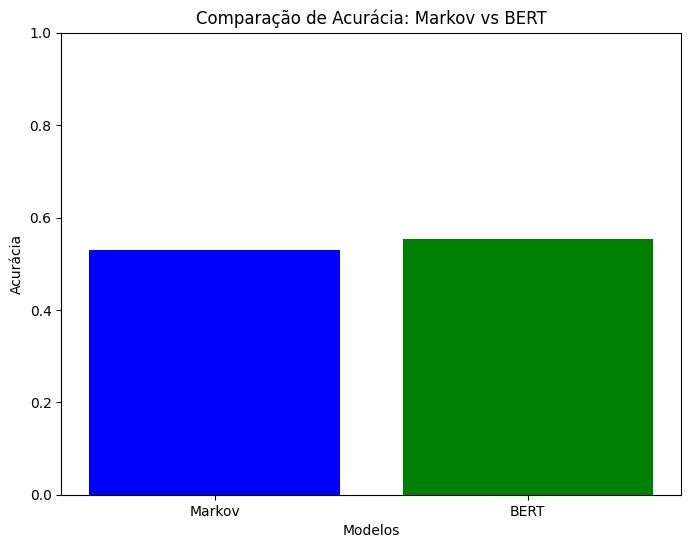

In [18]:
import matplotlib.pyplot as plt  # Importa a biblioteca para criar gráficos.

# Dados para o gráfico
models = ['Markov', 'BERT']  # Nomes dos modelos a serem comparados.
accuracies = [markov_accuracy, bert_accuracy]  # Acurácias dos dois modelos.

# Criação do gráfico de barras
plt.figure(figsize=(8, 6))  # Define o tamanho da figura (largura, altura).
plt.bar(models, accuracies, color=['blue', 'green'])  # Cria barras com cores distintas para cada modelo.
plt.ylim(0, 1)  # Define o limite do eixo y entre 0 e 1 (acurácia varia de 0 a 1).
plt.title('Comparação de Acurácia: Markov vs BERT')  # Título do gráfico.
plt.xlabel('Modelos')  # Rótulo do eixo x.
plt.ylabel('Acurácia')  # Rótulo do eixo y.
plt.show()  # Exibe o gráfico.

## Cross-Validation of the Markov Model

### Description

This cell performs cross-validation on the Markov model and plots the results to check for potential overfitting or underfitting issues.

### **Cross-Validation:**
- Uses `cross_val_score` to calculate accuracy across 5 folds of the training set.
- Plots the accuracy for each fold in a line chart with markers.

### **Chart:**
- Displays the accuracy for each fold in the cross-validation process.
- A horizontal line indicates the test set accuracy for comparison.
- Includes a title, axis labels, and legend for clarity.

### **Purpose:**
- Assess the consistency of the Markov model across different subsets of data.
- Detect overfitting (if test accuracy is much higher than fold accuracies) or underfitting (if all accuracies are low).

This chart helps understand whether the model is generalizing well or overly fitted to the training data, offering a more robust view of its performance.

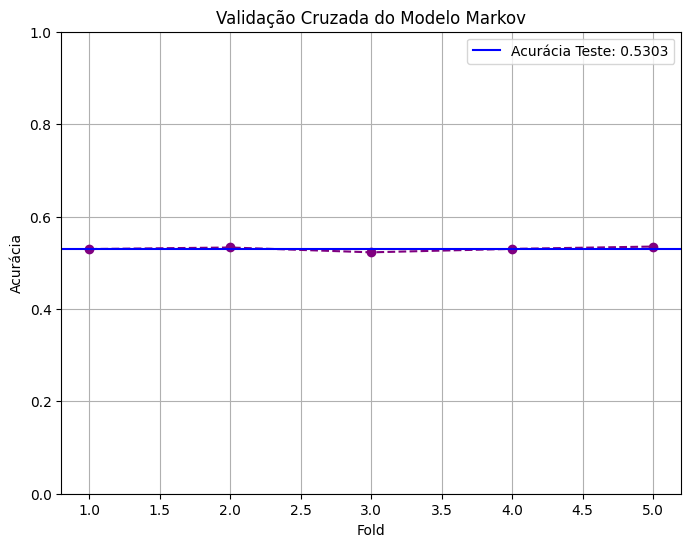

Média da acurácia na validação cruzada: 0.5300
Desvio padrão da acurácia na validação cruzada: 0.0042


In [19]:
from sklearn.model_selection import cross_val_score  # Importa função para validação cruzada.

# Realizar validação cruzada no modelo Markov
cv_scores = cross_val_score(markov_classifier, X_train_markov, y_train, cv=5)  # Calcula acurácia em 5 folds.

# Plotar os resultados da validação cruzada
plt.figure(figsize=(8, 6))  # Define o tamanho da figura.
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='purple')  # Plota a acurácia de cada fold.
plt.axhline(y=markov_accuracy, color='blue', linestyle='-', label=f'Acurácia Teste: {markov_accuracy:.4f}')  # Linha da acurácia no teste.
plt.title('Validação Cruzada do Modelo Markov')  # Título do gráfico.
plt.xlabel('Fold')  # Rótulo do eixo x (cada fold da validação cruzada).
plt.ylabel('Acurácia')  # Rótulo do eixo y.
plt.ylim(0, 1)  # Limite do eixo y entre 0 e 1.
plt.legend()  # Exibe a legenda.
plt.grid(True)  # Adiciona uma grade para facilitar a leitura.
plt.show()  # Exibe o gráfico.

# Exibir média e desvio padrão da validação cruzada
print(f"Média da acurácia na validação cruzada: {cv_scores.mean():.4f}")
print(f"Desvio padrão da acurácia na validação cruzada: {cv_scores.std():.4f}")